# Manual Testing

This file is designed to load in the saved models trained by main.py and evaluate them

In [1]:
import sys
sys.path.append('..')
from a2c_ppo_acktr import algo, utils
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from evaluation import evaluate
from tqdm import tqdm

import matplotlib.pyplot as plt

def load_model(algo='ppo', env=None, filename=None):
    '''
    Load a trained model from the algorithm
    '''
    if env is None and filename is None:
        raise
    file = 'trained_models/' + algo + '/'
    if env is not None:
        file = file + env + '.pt'
    elif filename is not None:
        file = file + filename
        
    model, rms = torch.load(file)

    return model, rms
    
%run model_evaluation

# Test running a single model and running Policy, FlexBase

In [ ]:
%run model_evaluation

model, obs_rms, kwargs = load_model_and_env('nav_auxiliary_tasks/nav_c4_auxwall1', 0)

action_randomizer = lambda step: np.random.choice([0, 1, 2])
results = forced_action_evaluate(model, obs_rms, forced_actions=action_randomizer, env_kwargs=kwargs, 
                                data_callback=nav_data_callback, num_episodes=1, with_activations=True)


obs, rnn_hxs, masks = results['obs'][0], results['hidden_states'][0], results['masks'][0]

import sys
sys.path.append('../')
from a2c_ppo_acktr.model import Policy

env = gym.make('NavEnv-v0', **kwargs)

model = Policy(obs.squeeze().shape, env.action_space, base='FlexBase', base_kwargs={'num_shared_layers': 0, 'auxiliary_heads': [[-1, 0, 1]]})
# model = Policy(obs.squeeze().shape, env.action_space, base='FlexBase', base_kwargs={'num_shared_layers': 0})

# model, obs_rms, kwargs = load_model_and_env('nav_invisible_shared/nav_c4_shared0.dist', 0)
action_randomizer = lambda step: np.random.choice([0, 1, 2])
results = forced_action_evaluate(model, obs_rms, forced_actions=action_randomizer, env_kwargs=kwargs, 
                                data_callback=nav_data_callback, num_episodes=1, with_activations=True)


In [6]:
model, obs_rms, kwargs = load_model_and_env('nav_auxiliary_tasks2/nav_c4_auxeuclid0', 0)
env = gym.make('NavEnv-v0', **kwargs)

In [18]:
def quick_vec_env(obs_rms, env_kwargs={}, env_name='NavEnv-v0', seed=0,
                 num_processes=1, eval_log_dir='/tmp/gym/_eval',
                 device=torch.device('cpu'), capture_video=False):
    eval_envs = make_vec_envs(env_name, seed + num_processes, num_processes,
                          None, eval_log_dir, device, True, 
                          capture_video=capture_video, 
                          env_kwargs=env_kwargs)

    vec_norm = utils.get_vec_normalize(eval_envs)
    if vec_norm is not None:
        vec_norm.eval()
        vec_norm.obs_rms = obs_rms
        
    return eval_envs


**Test making vec_envs and policy**

In [71]:
kwargs = {
    'task_structure': 4,
    'rew_structure': 'goal',
    'num_objects': 0,
    'wall_colors': 1,
    'poster': 1,
    'num_rays': 12,
    'fov': 1
}

env_kwargs = {'num_objects': 0, 'rew_structure': 'goal',
              'task_structure': 4, 'wall_colors': 1, 'num_rays': 12, 'fov': 1,
              'poster': 1, #distal
              'character_reset_pos': 1}
# env = gym.make('NavEnv-v0', **kwargs)
envs = make_vec_envs('NavEnv-v0', 0, 1, 0.99, '/tmp/gym/', torch.device('cpu'),
                     False, capture_video=False, env_kwargs=env_kwargs)
model = Policy(envs.observation_space.shape, envs.action_space, 
               base='FlexBase', base_kwargs={'hidden_size': 4})

obs = envs.reset()
rnn_hxs = torch.zeros(model.recurrent_hidden_state_size).view(1, -1)
masks = torch.ones([1, 1])

# model.base(obs, rnn_hxs, masks)
model.act(obs, rnn_hxs, masks)

{'value': tensor([[-0.0015]], grad_fn=<AddmmBackward0>),
 'actor_features': tensor([[ 0.0005,  0.0024,  0.0019, -0.0011]], grad_fn=<TanhBackward0>),
 'rnn_hxs': tensor([[ 0.0007, -0.0013,  0.0007,  0.0003]], grad_fn=<SqueezeBackward1>),
 'auxiliary_preds': tensor([[0.]]),
 'action': tensor([[1]]),
 'action_log_probs': tensor([[-1.3863]], grad_fn=<UnsqueezeBackward0>)}

In [72]:
model.evaluate_actions(obs, rnn_hxs, masks, torch.tensor([[1]]))

(tensor([[-0.0015]], grad_fn=<AddmmBackward0>),
 tensor([[-1.3863]], grad_fn=<UnsqueezeBackward0>),
 tensor(1.3863, grad_fn=<MeanBackward0>),
 tensor([[ 0.0007, -0.0013,  0.0007,  0.0003]], grad_fn=<SqueezeBackward1>),
 tensor([[0.]]))

## Example: Test Correlated 2-arm Bandits

In [2]:
# env_name = 'CartPole-v1'
env_name = 'Bandits-v0'
model, rms = load_model(env=env_name, algo='a2c')
log_dir = '/tmp/gym/_eval'
device = torch.device("cpu")


In [3]:
all_obs, all_actions, all_rewards, all_hidden_states, eval_envs = evaluate(model, rms, env_name, 1, 10, log_dir, device)

 Evaluation using 10 episodes: mean reward 77.30000



In [4]:
all_obs2 = torch.zeros(size=[len(all_obs)] + list(all_obs[0].shape))
all_actions2 = torch.zeros(size=[len(all_actions)] + list(all_actions[0].shape))
all_rewards2 = torch.zeros(size=[len(all_rewards)] + list(all_rewards[0].shape))
all_hidden_states2 = torch.zeros(size=[len(all_hidden_states)] + list(all_hidden_states[0].shape))

for i in range(len(all_obs)):
    all_obs2[i] = all_obs[i]
    all_actions2[i] = all_actions[i]
    all_rewards2[i] = all_rewards[i]
    all_hidden_states2[i] = all_hidden_states[i]

In [7]:
reward_probabilities = eval_envs.get_attr('reward_probabilities')

In [19]:
second_arm_probs = []
second_arm_choices = []
for i in range(all_actions2.shape[1]):
    second_arm_choices.append(torch.mean(all_actions2.T[0][i]))
    second_arm_probs.append(reward_probabilities[i][1])

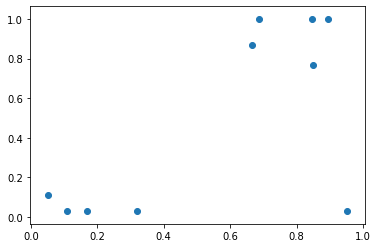

In [21]:
plt.scatter(second_arm_probs, second_arm_choices)

## Test Goal Dist Auxiliary Task

In [2]:
%run representation_analysis
%run model_evaluation

In [4]:

env_kwargs = {'num_objects': 0, 'rew_structure': 'goal',
              'task_structure': 2, 'wall_colors': 1, 'num_rays': 12, 'fov': 1,
              'poster': 1, 'auxiliary_tasks': [3, 2], 'auxiliary_task_args': [None, 3],
              'character_reset_pos': 1}
# env = gym.make('NavEnv-v0', **kwargs)
envs = make_vec_envs('NavEnv-v0', 0, 1, 0.99, '/tmp/gym/', torch.device('cpu'),
                     False, capture_video=False, env_kwargs=env_kwargs)
model = Policy(envs.observation_space.shape, envs.action_space, 
               base='FlexBase', base_kwargs={'hidden_size': 4, 'auxiliary_heads': [[-1, 0, 1]]})

obs = envs.reset()
rnn_hxs = torch.zeros(model.recurrent_hidden_state_size).view(1, -1)
masks = torch.ones([1, 1])

# model.base(obs, rnn_hxs, masks)
model.act(obs, rnn_hxs, masks)
envs.step(torch.tensor([[1]]))

(tensor([[ 0.0012,  0.0012,  0.0012,  0.0012,  0.0012,  0.0012,  0.0012,  0.0012,
           0.0012,  0.0012,  0.0012,  0.0012, -0.7812, -0.7854, -0.7913, -0.7990,
          -0.8084, -0.8194, -0.8318, -0.8455, -0.8601, -0.8753, -0.7181, -0.7047]]),
 tensor([[0.]]),
 array([False]),
 [{'auxiliary': array([0.39090402, 0.29447325])}])

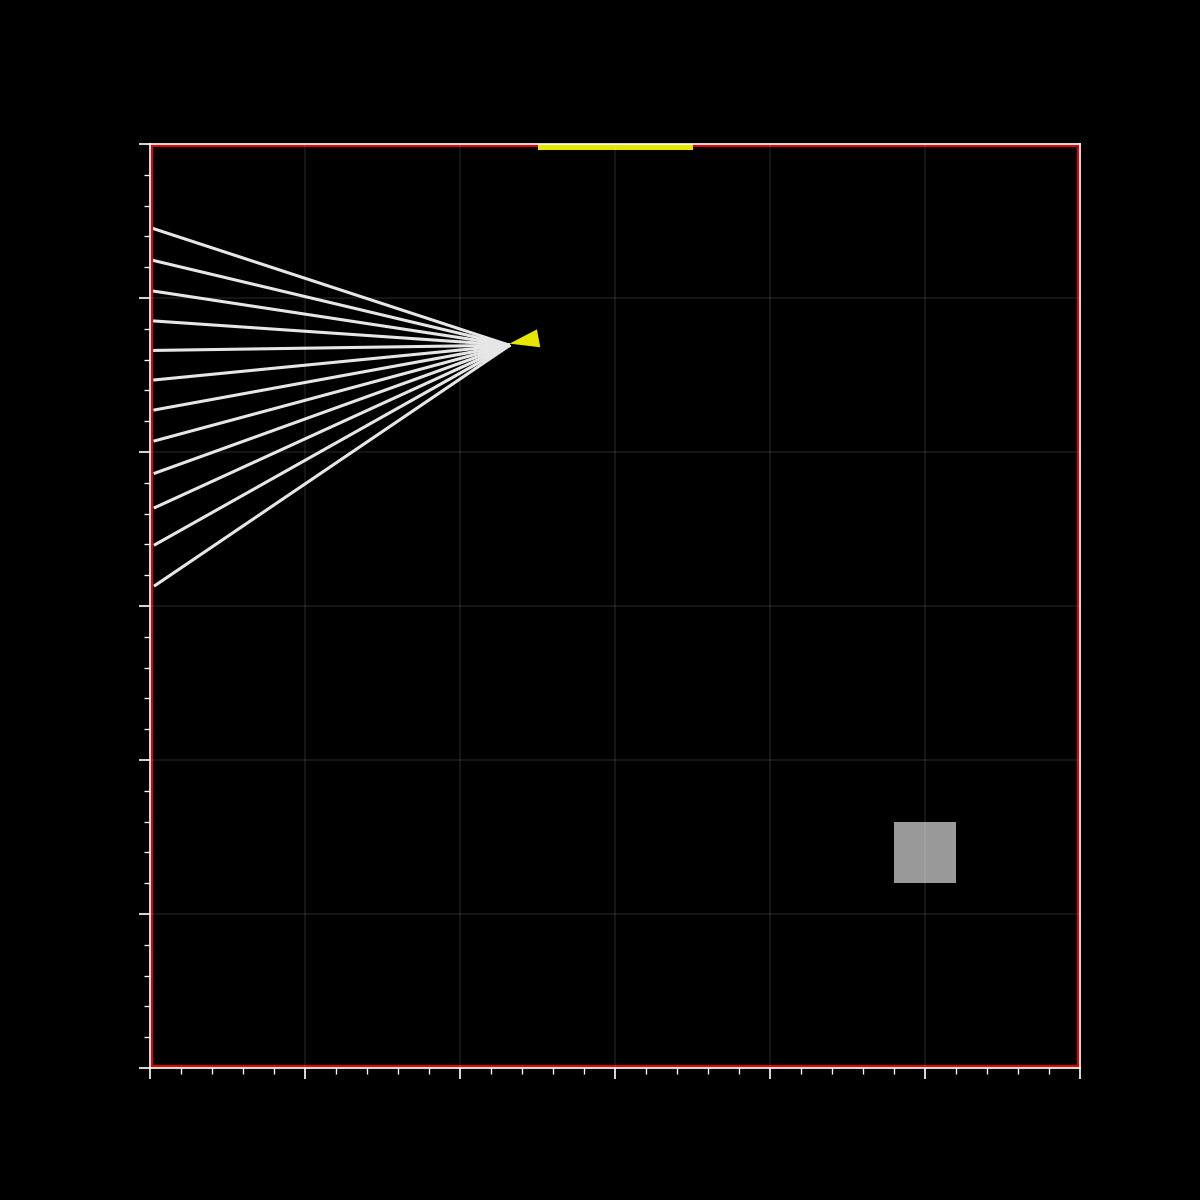

In [7]:
env = gym.make('NavEnv-v0', **env_kwargs)
env.reset()
env.render('human')

(array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.19253379, 0.18988893, 0.18860703,
       0.1886428 , 0.1899975 , 0.19271903, 0.19690612, 0.20271739,
       0.21038669, 0.22024781, 0.22249877, 0.2002063 ]), 1.0, True, {'auxiliary': array([0.02991624, 0.09356436])})


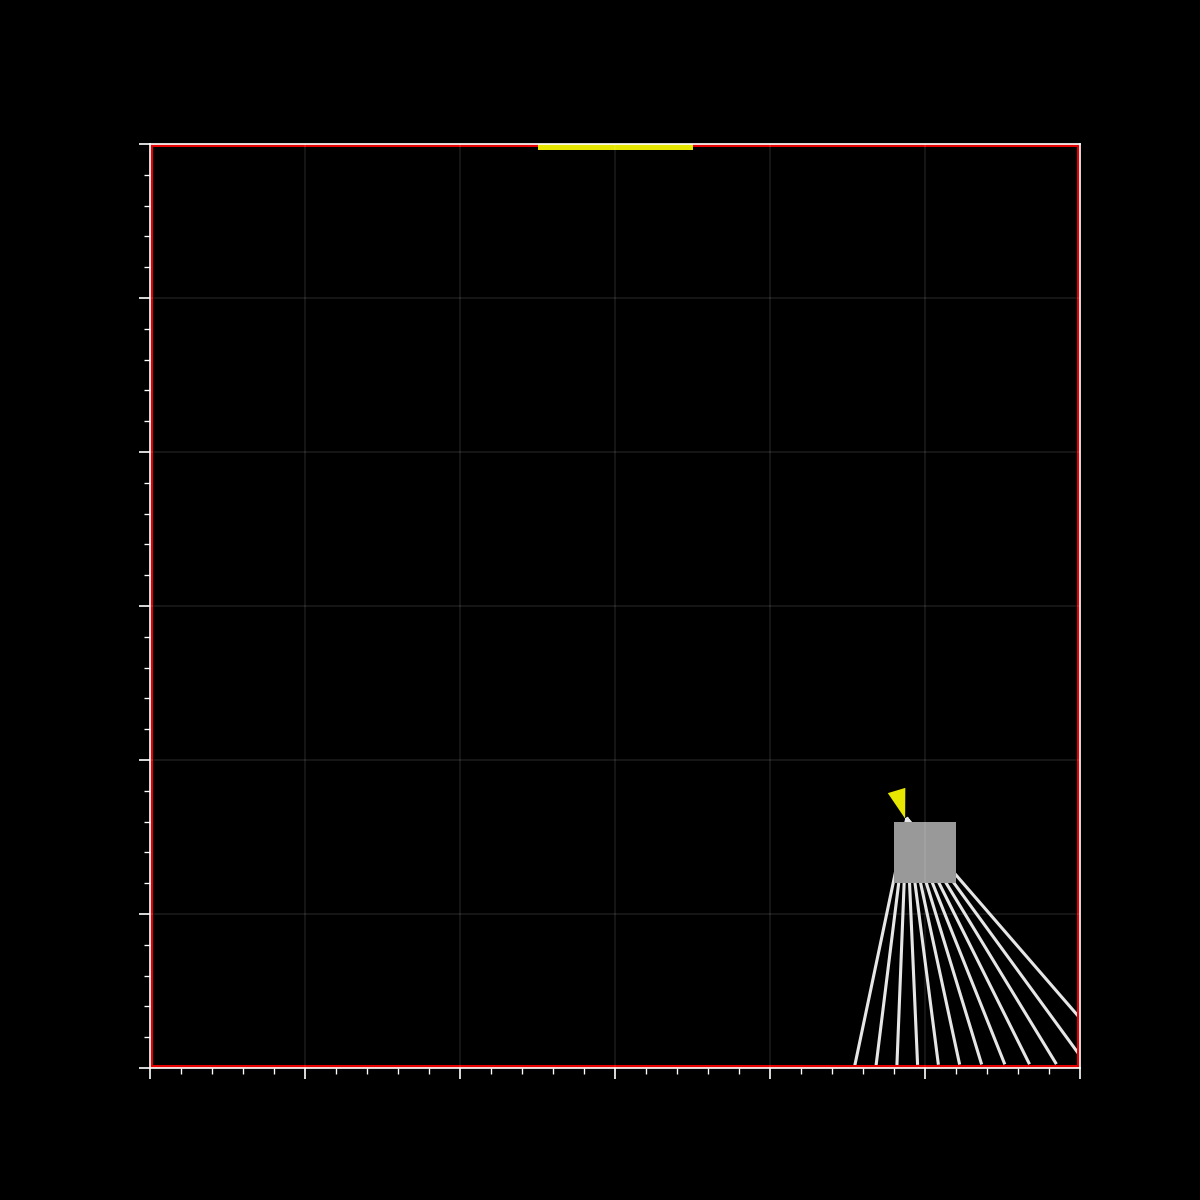

In [56]:
print(env.step(torch.tensor([[1]])))
env.render('human')

In [36]:
np.linalg.norm(envs.get_attr('character')[0].pos - envs.get_attr('boxes')[0][-1].center)

185.09814297225236

# Manual Testing of Training Code

In [74]:
from model_evaluation import load_model_and_env

model_name = 'nav_poster_netstructure/nav_pdistal_width64batch200'
model, obs_rms, env_kwargs = load_model_and_env(model_name, 0)

In [36]:

vec_norm = utils.get_vec_normalize(envs)

In [95]:

from a2c_ppo_acktr.storage import RolloutStorage
from a2c_ppo_acktr.envs import make_vec_envs
from a2c_ppo_acktr import algo, utils
import torch
from collections import deque

#Overall training params
num_steps = 10 #batch steps
num_processes = 1
env_name = 'NavEnv-v0'
seed = 0
gamma = 0.99
log_dir = '/tmp/gym/'
device = torch.device('cpu')
capture_video = False

#Training update step params
use_gae = False
gae_lambda = 0.95

#Agent update params
clip_param = 0.2
ppo_epoch = 4
num_mini_batch = 1 #how many minibatches to divide our num_steps*num_processes batch of rollouts into
value_loss_coef = 0.5
entropy_coef = 0.01
auxiliary_loss_coef = 0.3
lr = 7e-4
eps = 1e-5
max_grad_norm = 0.5


num_updates = 1 #total batch_size updates to do

# episode_rewards = deque(maxlen=10)
agent, envs, rollouts = initialize_ppo_training(model, obs_rms, env_kwargs=env_kwargs)
for j in range(num_updates):
    populate_rollouts(model, envs, rollouts, num_steps)
    update_model(agent, rollouts, use_gae=use_gae, gamma=gamma, gae_lambda=gae_lambda)


In [28]:
import sys
sys.path.append('..')
from a2c_ppo_acktr.storage import RolloutStorage
from a2c_ppo_acktr.envs import make_vec_envs
from a2c_ppo_acktr import algo, utils
from  a2c_ppo_acktr.model import Policy
import torch
from collections import deque

'''
First 4 parameters are for shared recurrent layer. Can freeze these by setting
requires_grad = False
'''

def populate_rollouts(model, envs, rollouts, num_steps):
    for step in range(num_steps):
        #Generate rollouts for num_steps batch
        with torch.no_grad():
            outputs = model.act(rollouts.obs[step], rollouts.recurrent_hidden_states[step],
                                rollouts.masks[step])
            action = outputs['action']
            value = outputs['value']
            action_log_prob = outputs['action_log_probs']
            recurrent_hidden_states = outputs['rnn_hxs']
            # auxiliary_preds = outputs['auxiliary_preds']

        obs, reward, done, infos = envs.step(action)

        masks = torch.FloatTensor([[0.0] if done_ else [1.0] for done_ in done])
        bad_masks = torch.FloatTensor([[0.0] if 'bad_transition' in info.keys() else [1.0] for info in infos])
        rollouts.insert(obs, recurrent_hidden_states, action, action_log_prob, value, reward, masks, bad_masks)

        
def update_model(agent, rollouts, use_gae=False, gamma=0.99, gae_lambda=0.95,
                 after_update=True):
    
    #Compute last value to be used for the update
    with torch.no_grad():
        next_value = agent.actor_critic.get_value(rollouts.obs[-1], rollouts.recurrent_hidden_states[-1],
                                            rollouts.masks[-1]).detach()
    
    rollouts.compute_returns(next_value, use_gae, gamma, gae_lambda)
    value_loss, action_loss, dist_entropy, approx_kl, clipfracs, auxiliary_loss = agent.update(rollouts)
    
    if after_update:
        rollouts.after_update()
        
    return value_loss, action_loss, dist_entropy, approx_kl, clipfracs, auxiliary_loss


def initialize_ppo_training(model=None, obs_rms=None, env_name='NavEnv-v0', env_kwargs={},
                            nn_base='FlexBase', nn_base_kwargs={}, recurrent=True,
                            num_steps=10, num_processes=1, seed=0, ppo_epoch=4, clip_param=0.5,
                            num_mini_batch=1, value_loss_coef=0.5, entropy_coef=0.01, 
                            auxiliary_loss_coef=0.3, gamma=0.99, lr=7e-4, eps=1e-5, max_grad_norm=0.5,
                            log_dir='/tmp/gym/', device=torch.device('cpu'), 
                            capture_video=False):
    
    #Initialize vectorized environments
    envs = make_vec_envs(env_name, seed, num_processes, gamma, log_dir, device, False,
                         capture_video=capture_video, env_kwargs=env_kwargs)

    if model is None:
        model = Policy(envs.observation_space.shape,
                       envs.action_space,
                       base='FlexBase',
                       base_kwargs={'recurrent': recurrent,
                           **nn_base_kwargs})
        model.to(device)
    
    #Wrap model with an agent algorithm object
    agent = algo.PPO(model, clip_param, ppo_epoch, num_mini_batch,
                     value_loss_coef, entropy_coef, auxiliary_loss_coef, lr=lr,
                     eps=eps, max_grad_norm=max_grad_norm)


    #If loading a previously trained model, pass an obs_rms object to set the vec envs to use
    vec_norm = utils.get_vec_normalize(envs)
    if vec_norm is not None and obs_rms is not None:
        vec_norm.obs_rms = obs_rms


    #Initialize storage
    rollouts = RolloutStorage(num_steps, num_processes, envs.observation_space.shape, envs.action_space,
                              model.recurrent_hidden_state_size, model.auxiliary_output_size)
    #Storage objects initializes a bunch of empty tensors to store information, e.g.
    #obs has shape (num_steps+1, num_processes, obs_shape)
    #rewards has shape (num_steps, num_processes, 1)

    #obs, recurrent_hidden_states, value_preds, returns all have batch size num_steps+1
    #rewards, action_log_probs, actions, masks, auxiliary_preds, auxiliary_truths all have batch size num_steps
    obs = envs.reset()
    rollouts.obs[0].copy_(obs)
    rollouts.to(device)
    
    return agent, envs, rollouts

In [27]:
'''
Testing freezing params

We load a trained model, freeze the recurrent layer and train, showing that indeed parameters
besides the recurrent layer have updated
'''

from model_evaluation import load_model_and_env

model_name = 'nav_poster_netstructure/nav_pdistal_width64batch200'
model, obs_rms, env_kwargs = load_model_and_env(model_name, 0)

params = list(model.parameters())
temp_param_vals = []
for i in range(4):
    params[i].requires_grad=False
for i in range(len(params)):
    temp_param_vals.append(params[i].data.clone())
# list(model.parameters())[0].requires_grad=False



num_updates = 1 #total batch_size updates to do
num_steps = 10

agent, envs, rollouts = initialize_ppo_training(model, obs_rms, env_kwargs=env_kwargs)
for j in range(num_updates):
    populate_rollouts(model, envs, rollouts, num_steps)
    update_model(agent, rollouts)
    
for i in range(len(params)):
    print(temp_param_vals[i].squeeze()[0] - params[i].data.squeeze()[0]) 

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor(0.)
tensor(0.)
tensor([ 0.0020, -0.0001,  0.0021, -0.0019, -0.0016, -0.0021, -0.0022,  0.0019,
         0.0021,  0.0023, -0.0017, -0.0019,  0.0021, -0.0025, -0.0020, -0.0021,
        -0.0022,  0.0023,  0.0022, -0.0021, -0.0022,  0.0022, -0.0020,  0.0019,
        -0.0021, -0.0021, -0.0019, -0.0023,  0.0024, -0.0020, -0.0025,  0.0023,
        -0.0021,  0.0019,  0.0023,  0.0023,  0.0022,  0.0025, -0.0024,  0.0020,
         0.0022, -0.0021,  0.0018,  0.0020,  0.0022, -0.0021,  0.0020, -0.0020,
         0.0018,  0.0023,  0.0021, -0.0019,  0.0016,  0.0023, -0.0018,  0.0020,
        -0.0017, -0.0018, -0.002

IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

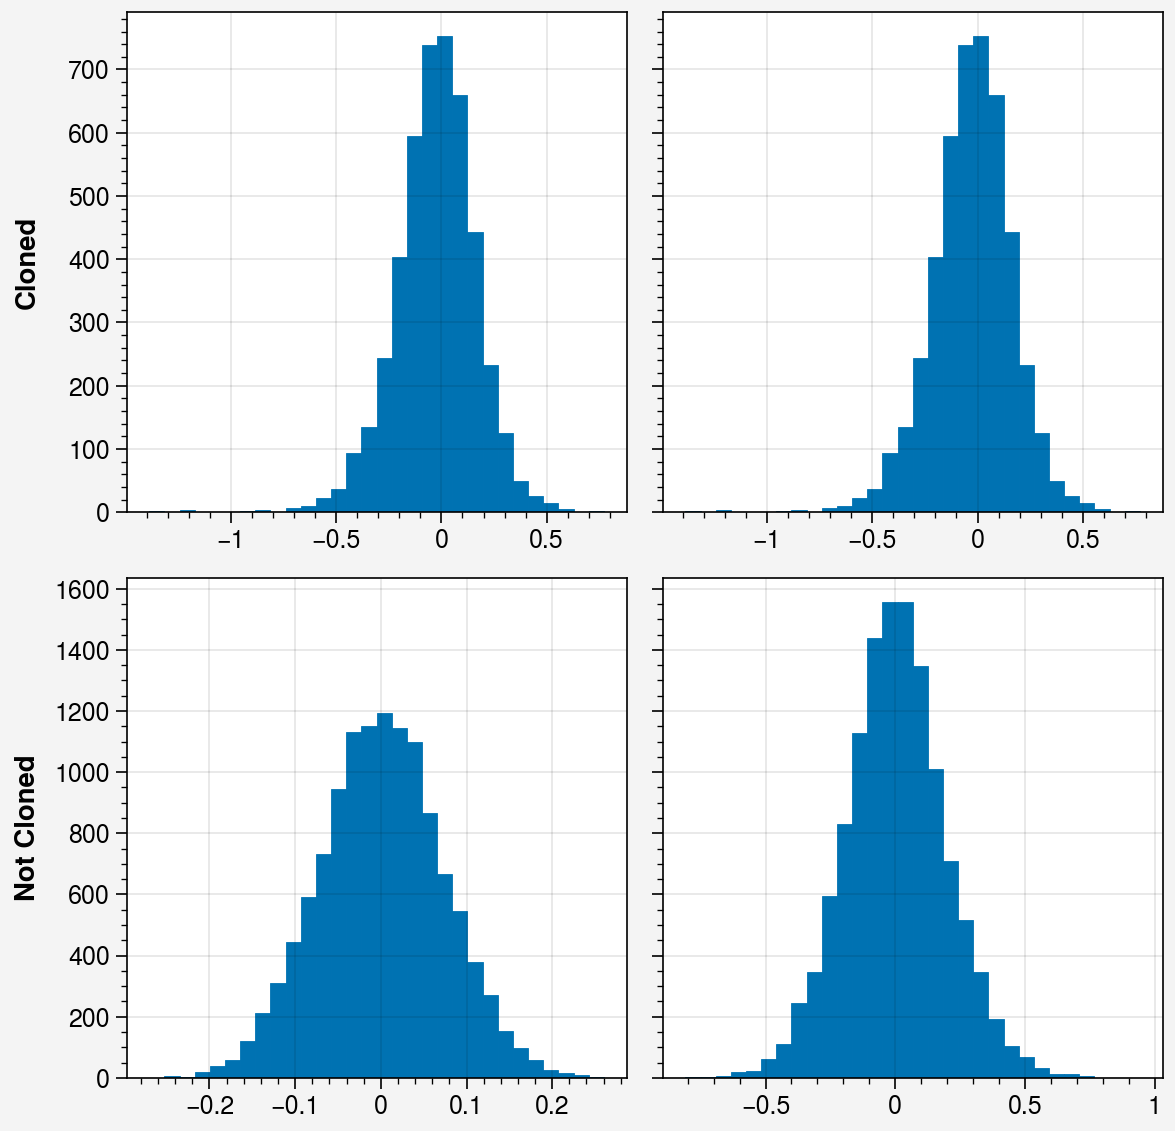

In [81]:
'''
Testing cloning params

We initiate a new model and then clone the first set of parameters from a trained model onto it
'''

from model_evaluation import load_model_and_env

model_name = 'nav_poster_netstructure/nav_pdistal_width64batch200'
model, obs_rms, env_kwargs = load_model_and_env(model_name, 0)

agent, envs, rollouts = initialize_ppo_training(env_kwargs=env_kwargs)



import matplotlib.pyplot as plt
import proplot as pplt

fig, ax = pplt.subplots(nrows=2, ncols=2, sharex=False)
ax.format(leftlabels=['Cloned', 'Not Cloned'])
params1 = list(agent.actor_critic.parameters())
params2 = list(model.parameters())

params1[0].data.copy_(params2[0].data)

for i in range(2):
    ax[i, 0].hist(params1[i].reshape(-1).detach().numpy(), bins=30)
    ax[i, 1].hist(params2[i].reshape(-1).detach().numpy(), bins=30)

# Manual Testing of env kwargs

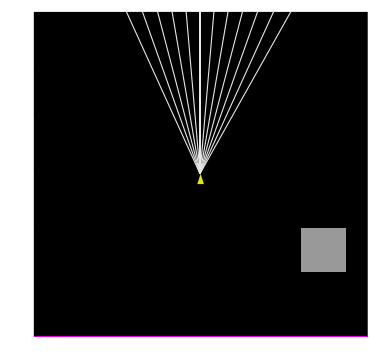

In [2]:
env_kwargs = pickle.load(open('../trained_models/ppo/meta_poster_width/meta_peast_fixposwidth16_env', 'rb'))
env_kwargs = pickle.load(open('../trained_models/ppo/meta_poster_width/meta_peast_fixposwidth16largegoal_env', 'rb'))
env_kwargs = pickle.load(open('../trained_models/ppo/report_poster_width/report_pdistal_width16_env', 'rb'))
env_kwargs = pickle.load(open('../trained_models/ppo/meta_poster/meta_c4_fixposwidth16largegoal_env', 'rb'))

env_kwargs['task_structure'] = 5

env = gym.make('NavEnv-v0', **env_kwargs)
env.reset()
env.render('human')

In [2]:
model_name = 'nav_poster_netstructure/nav_pdistal_width64batch200'
model, obs_rms, env_kwargs = load_model_and_env(model_name, 0)

list(model.parameters())[0]

Parameter containing:
tensor([[-0.2363, -0.1641, -0.2136,  ..., -0.0875, -0.0453,  0.0504],
        [ 0.0946,  0.1231,  0.0256,  ...,  0.1203,  0.4508,  0.4429],
        [ 0.0444,  0.1615,  0.0574,  ..., -0.0182, -0.1240, -0.2136],
        ...,
        [ 0.0231,  0.0861, -0.0638,  ...,  0.0427, -0.0582, -0.4408],
        [-0.0795, -0.0732, -0.0005,  ...,  0.0230, -0.0275,  0.0313],
        [ 0.3718,  0.0880,  0.1137,  ..., -0.0081, -0.0256,  0.0841]],
       requires_grad=True)

In [3]:
env_kwargs['task_structure'] = 3
env_kwargs['fixed_reset'] = [np.array([150., 150.]), np.pi/2]

In [4]:
env = gym.make('NavEnv-v0', **env_kwargs)

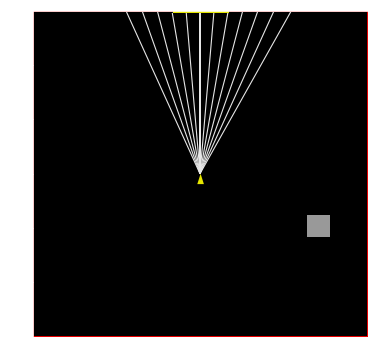

In [5]:
env.reset()
env.render('human')

In [26]:
print(env.step(torch.tensor([1])))
env.render('human')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [27]:
a = None

In [30]:
type(a) == type(None)

True

# Manual Testing of scheduler reader and main

In [41]:
%run ../testargs

# convert_config_to_command('nav_pdistal_width16clone1_t0', config_folder='../experiment_configs/')
# convert_config_to_command('nav_pdistal_width16auxwall1auxloss0.1_t0', config_folder='../experiment_configs/')
convert_config_to_command('meta_peast_width16_t0', config_folder='../experiment_configs/')

'python main.py --wandb-project-name Nav_Shared_Layers --exp-name meta_peast_width16_t0 --save-name meta_peast_width16_t0 --num-env-steps 5000 --env-name NavEnv-v0 --algo ppo --num-mini-batch 1 --num-processes 1 --num-steps 10 --recurrent --seed 0 --no-cuda --env-kwargs task_structure=3 rew_structure=goal num_objects=0 wall_colors=1 poster=1 num_rays=12 fov=1 character_reset_pos=1 fixed_reset=[array([150.,150.]),1.5707963267948966] max_steps=1000 --nn-base FlexBase --nn-base-kwargs hidden_size=16 --config-file-name meta_peast_width16_t0 '

In [6]:
%run ../testargs --wandb-project-name Nav_Shared_Layers --exp-name nav_pdistal_width16clone1_t0 --save-name nav_pdistal_width16clone1_t0 --num-env-steps 5000000 --env-name NavEnv-v0 --algo ppo --num-mini-batch 1 --num-processes 1 --num-steps 200 --checkpoint-interval 10 --recurrent --seed 0 --no-cuda --env-kwargs num_objects=0 rew_structure=goal task_structure=2 wall_colors=1 num_rays=12 fov=1 poster=1 character_reset_pos=1 --nn-base FlexBase --nn-base-kwargs hidden_size=16 --clone-parameter-experiment --clone-args clone_path=../trained_models/ppo/nav_poster_netstructure/nav_pdistal_width16batch200_t1.pt clone_layers=4 freeze=True --config-file-name nav_pdistal_width16clone1_t0

['num_objects=0', 'rew_structure=goal', 'task_structure=2', 'wall_colors=1', 'num_rays=12', 'fov=1', 'poster=1', 'character_reset_pos=1']
['hidden_size=16']
['clone_path=../trained_models/ppo/nav_poster_netstructure/nav_pdistal_width16batch200_t1.pt', 'clone_layers=4', 'freeze=True']


In [3]:
import copy
import glob
import os
import time
from collections import deque
from shutil import copyfile

import gym
import gym_nav
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from a2c_ppo_acktr import algo, utils
from a2c_ppo_acktr.algo import gail
from a2c_ppo_acktr.arguments import get_args
from a2c_ppo_acktr.envs import make_vec_envs
from a2c_ppo_acktr.model import Policy
from a2c_ppo_acktr.storage import RolloutStorage
from evaluation import evaluate

from scheduler import write_latest_exp_complete

ModuleNotFoundError: No module named 'evaluation'

In [27]:
device = torch.device("cuda:0" if args.cuda else "cpu")
print('initializing environments')
envs = make_vec_envs(args.env_name, args.seed, args.num_processes,
                     args.gamma, args.log_dir, device, False, capture_video=args.capture_video,
                     env_kwargs=args.env_kwargs)

loaded_model = False
# print(args.cont)
print('initializing model')
print(args.save_interval)

#Andy: for continuing an experiment, args.cont is True
if args.cont:
    loaded_model = True
    actor_critic, obs_rms = torch.load(save_path)

if not loaded_model:
    actor_critic = Policy(
        envs.observation_space.shape,
        envs.action_space,
        base=args.nn_base,
        base_kwargs={'recurrent': args.recurrent_policy, 
                     **args.nn_base_kwargs})

    #Andy: if cloning parameters, do it here. We are assuming
    #that the target cloning network has the appropriate parameter
    #sizes
    if args.clone_parameter_experiment:
        clone_args = args.clone_args
        clone_actor_critic, obs_rms = torch.load(clone_args['clone_path'])
        clone_layers = clone_args['clone_layers']
        freeze_layers = clone_args['freeze']

        clone_params = list(clone_actor_critic.parameters())
        actor_critic_params = list(actor_critic.parameters())

        if type(clone_layers) == int:
            clone_layers = range(clone_layers)
        if type(freeze_layers) == bool:
            freeze_layers = [freeze_layers]*len(clone_layers)
        for i, layer in enumerate(clone_layers):
            freeze = freeze_layers[i]

            actor_critic_params[layer].data.copy_(clone_params[layer].data)
            if freeze:
                actor_critic_params[layer].requires_grad = False

    actor_critic.to(device)

initializing environments
initializing model
100


# Terminal prediction wrapper

In [1]:
from stable_baselines3.common.vec_env import (DummyVecEnv, SubprocVecEnv,
                                              VecEnvWrapper)
import sys
sys.path.append('..')
from a2c_ppo_acktr.envs import make_env, VecNormalize, VecPyTorch, make_vec_envs
import proplot as pplt
from collections import deque

In [226]:
class AuxVecPyTorch(VecEnvWrapper):
    def __init__(self, venv, device, auxiliary_tasks=[], auxiliary_task_args=[]):
        """Return only every `skip`-th frame"""
        super(AuxVecPyTorch, self).__init__(venv)
        self.device = device
        
        available_auxiliary_tasks = {
            'terminal': 1
        }
        auxiliary_task_to_idx = {
            'terminal': 0
        }
        
        self.auxiliary_tasks = []
        self.auxiliary_task_args = auxiliary_task_args
        for task in auxiliary_tasks:
            if type(task) == int:
                self.auxiliary_tasks.append(task)
            elif task not in available_auxiliary_tasks.keys():
                raise NotImplementedError('Auxiliary task {} not found. Available options are '.format(
                    task, ', '.join(available_auxiliary_tasks.keys())))
            else:
                self.auxiliary_tasks.append(auxiliary_task_to_idx[task])

        self.episode_lengths = deque(maxlen=200)
        self.episode_lengths.append(200)

    def reset(self):
        obs = self.venv.reset()
        obs = torch.from_numpy(obs).float().to(self.device)
        return obs

    def step_async(self, actions):
        if isinstance(actions, torch.LongTensor):
            # Squeeze the dimension for discrete actions
            actions = actions.squeeze(1)
        actions = actions.cpu().numpy()
        self.venv.step_async(actions)

    def step_wait(self):
        obs, reward, done, info = self.venv.step_wait()
        obs = torch.from_numpy(obs).float().to(self.device)
        reward = torch.from_numpy(reward).unsqueeze(dim=1).float()
        
        
        for t, task in enumerate(self.auxiliary_tasks):
            #Note we assume that 'current_steps' is an attribute of the
            # environment. We could rewrite this so that the wrapper itself
            # keeps track of step counts so it becomes fully environment independent
            if task == 0:
                steps = self.venv.get_attr('current_steps')
                mean_steps = np.mean(self.episode_lengths)
                for n, i in enumerate(info):
                    if 'episode' in i.keys():
                        self.episode_lengths.append(i['episode']['l'])
                    if 'auxiliary' in i.keys():
                        i['auxiliary'] = np.append(i['auxiliary'], [steps[n]/mean_steps])
                    else:
                        i['auxiliary'] = np.array([steps[n]/mean_steps])
        
        
        return obs, reward, done, info

In [8]:
env_kwargs = pickle.load(open('../trained_models/ppo/nav_pdistal_batchaux/nav_pdistal_batch128auxnone_env', 'rb'))

In [4]:
env_kwargs = pickle.load(open('../trained_models/ppo/nav_poster_netstructure/nav_pdistal_width16batch200_env', 'rb'))

In [150]:
env = gym.make('NavEnv-v0', **env_kwargs)

In [20]:
aux_wrapper_args = {
    'auxiliary_tasks': [0],
    'auxiliary_task_args': [None]
}

envs = make_vec_envs('NavEnv-v0', 0, 5, 0.99, '/tmp/gym/', torch.device('cpu'),
                     False, capture_video=False, env_kwargs=env_kwargs, **aux_wrapper_args)


In [163]:


envs = [make_env('NavEnv-v0', 0, i, '/tmp/gym/', False, False, env_kwargs)
       for i in range(5)]

envs2 = SubprocVecEnv(envs)

envs3 = VecNormalize(envs2)

# envs4 = VecPyTorch(envs3, torch.device('cpu'))
envs4 = AuxVecPyTorch(envs3, torch.device('cpu'))

In [8]:
config = pickle.load(open('../experiment_configs/nav_pdistal_batch16auxrewexplorenonorm_t1', 'rb'))
env_kwargs = config['env_kwargs']

{'num_objects': 0,
 'rew_structure': 'explore',
 'task_structure': 2,
 'wall_colors': 1,
 'num_rays': 12,
 'fov': 1,
 'poster': 1,
 'character_reset_pos': 1}

In [9]:
envs = make_vec_envs('NavEnv-v0', 0, 5, 0.99, '/tmp/gym/', torch.device('cpu'),
                     False, capture_video=False, env_kwargs=env_kwargs, normalize=False)


In [11]:
envs.reset()

tensor([[0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667,
         0.1667, 0.1667, 0.1667, 0.3889, 0.3951, 0.4044, 0.4170, 0.4336, 0.4548,
         0.4818, 0.5159, 0.5595, 0.6157, 0.6016, 0.5716],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667,
         0.1667, 0.1667, 0.1667, 0.4651, 0.4464, 0.4320, 0.4213, 0.4140, 0.4097,
         0.4083, 0.4098, 0.4141, 0.4215, 0.4322, 0.4467],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667,
         0.1667, 0.1667, 0.1667, 0.3127, 0.3088, 0.3072, 0.3077, 0.1720, 0.1099,
         0.0812, 0.0647, 0.0541, 0.0468, 0.0414, 0.0374],
        [0.1667, 0.1667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667,
         0.1667, 0.1667, 0.1667, 0.2142, 0.2106, 0.2062, 0.2056, 0.2064, 0.2087,
         0.2126, 0.2181, 0.2255, 0.2379, 0.2503, 0.2661],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667,
         0.1667, 0.1667, 0.1667, 0.0380

In [33]:
envs.step(torch.full((5, 1), 1))

(tensor([[1.6667e-01, 1.6667e-01, 1.6667e-01, 1.6667e-01, 1.6667e-01, 1.6667e-01,
          1.6667e-01, 1.6667e-01, 1.6667e-01, 1.6667e-01, 1.6667e-01, 1.6667e-01,
          1.9027e-03, 1.9330e-03, 1.9782e-03, 2.0402e-03, 2.1213e-03, 2.2252e-03,
          2.3570e-03, 2.5241e-03, 2.7370e-03, 3.0121e-03, 3.3747e-03, 3.8670e-03],
         [1.6667e-01, 1.6667e-01, 1.6667e-01, 1.6667e-01, 1.6667e-01, 1.6667e-01,
          1.6667e-01, 1.6667e-01, 1.6667e-01, 1.6667e-01, 1.6667e-01, 1.6667e-01,
          2.6848e-03, 2.5767e-03, 2.4937e-03, 2.4322e-03, 2.3899e-03, 2.3651e-03,
          2.3570e-03, 2.3654e-03, 2.3904e-03, 2.4331e-03, 2.4949e-03, 2.5784e-03],
         [1.6667e-01, 1.6667e-01, 1.6667e-01, 1.6667e-01, 1.6667e-01, 1.6667e-01,
          1.6667e-01, 1.6667e-01, 1.6667e-01, 1.6667e-01, 1.6667e-01, 1.6667e-01,
          2.3631e-01, 2.3343e-01, 2.3220e-01, 1.1671e-02, 4.9952e-03, 3.1917e-03,
          2.3570e-03, 1.8788e-03, 1.5709e-03, 1.3578e-03, 1.2030e-03, 1.0866e-03],
         [6.6

# Run episodes

In [41]:
%run model_evaluation
%run representation_analysis

In [34]:
res.keys()

dict_keys(['obs', 'actions', 'rewards', 'hidden_states', 'dones', 'masks', 'envs', 'data', 'activations', 'values', 'actor_features', 'ep_ends', 'lens'])

In [75]:
import math
import matplotlib.pyplot as plt

def draw_character(pos, angle, size=10, ax=None, draw_color=[0.9, 0.9, 0, 0.3]):
    angle1 = angle - 0.3
    angle2 = angle + 0.3
    point1 = [pos[0], pos[1]]
    point2 = [pos[0] - math.cos(angle1)*size, pos[1] - math.sin(angle1)*size]
    point3 = [pos[0] - math.cos(angle2)*size, pos[1] - math.sin(angle2)*size]

    poly = plt.Polygon([point1, point2, point3], fc=draw_color)

    if ax == None:
        plt.gca().add_patch(poly)
    else:
        ax.add_patch(poly)


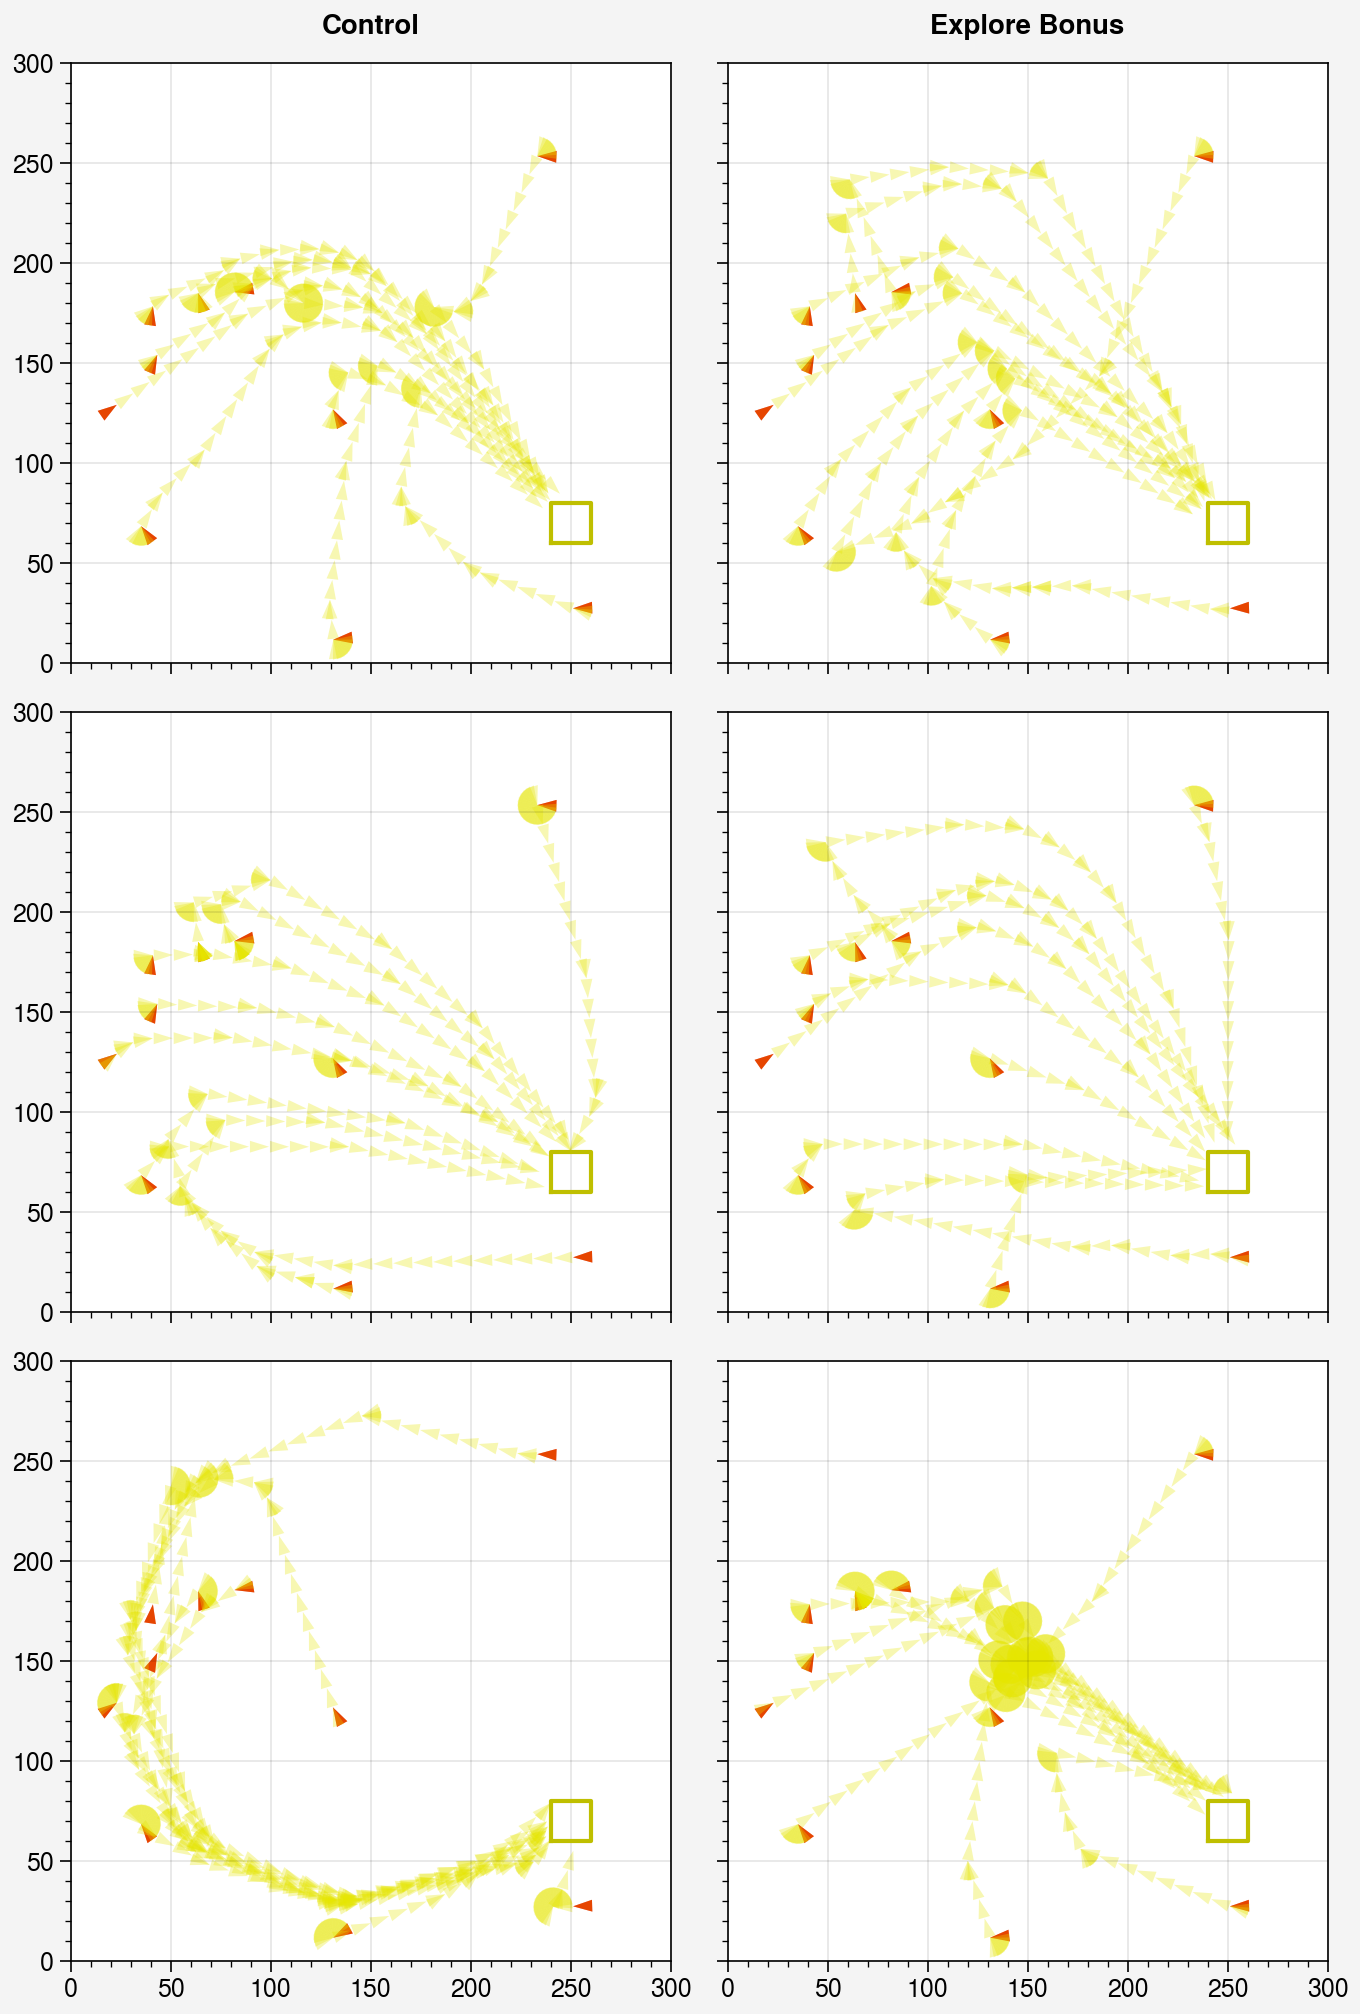

In [87]:
aux_tasks = ['none', 'rewexplore']
aux_task_labels = ['Control', 'Explore Bonus']
batch = 16

ncols = 2
nrows = 3

fig, axs = pplt.subplots(ncols=ncols, nrows=nrows, refwidth=3)
axs.format(xlim=(0, 300), ylim=(0, 300), toplabels=aux_task_labels)

ress = []

# for n, ax in enumerate(ax):

for x in range(nrows):
    for y in range(ncols):
        aux = aux_tasks[y]
        ax = axs[x, y]
    
        exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}'
        model, obs_rms, kwargs = load_model_and_env(exp_name, x)

        res = evalu(model, obs_rms, n=10, data_callback=poster_data_callback, env_kwargs=kwargs)
        ress.append(res)

        ep_pos = split_by_ep(np.vstack(res['data']['pos']), res['dones'])
        ep_angle = split_by_ep(np.vstack(res['data']['angle']), res['dones'])
        draw_box(ax=ax)
        for pos, angles in zip(ep_pos, ep_angle):
            for i, (p, a) in enumerate(zip(pos, angles)):
                if i == 0:
                    draw_character(p, a, ax=ax, draw_color=[0.9, 0, 0, 1])
                draw_character(p, a, ax=ax)

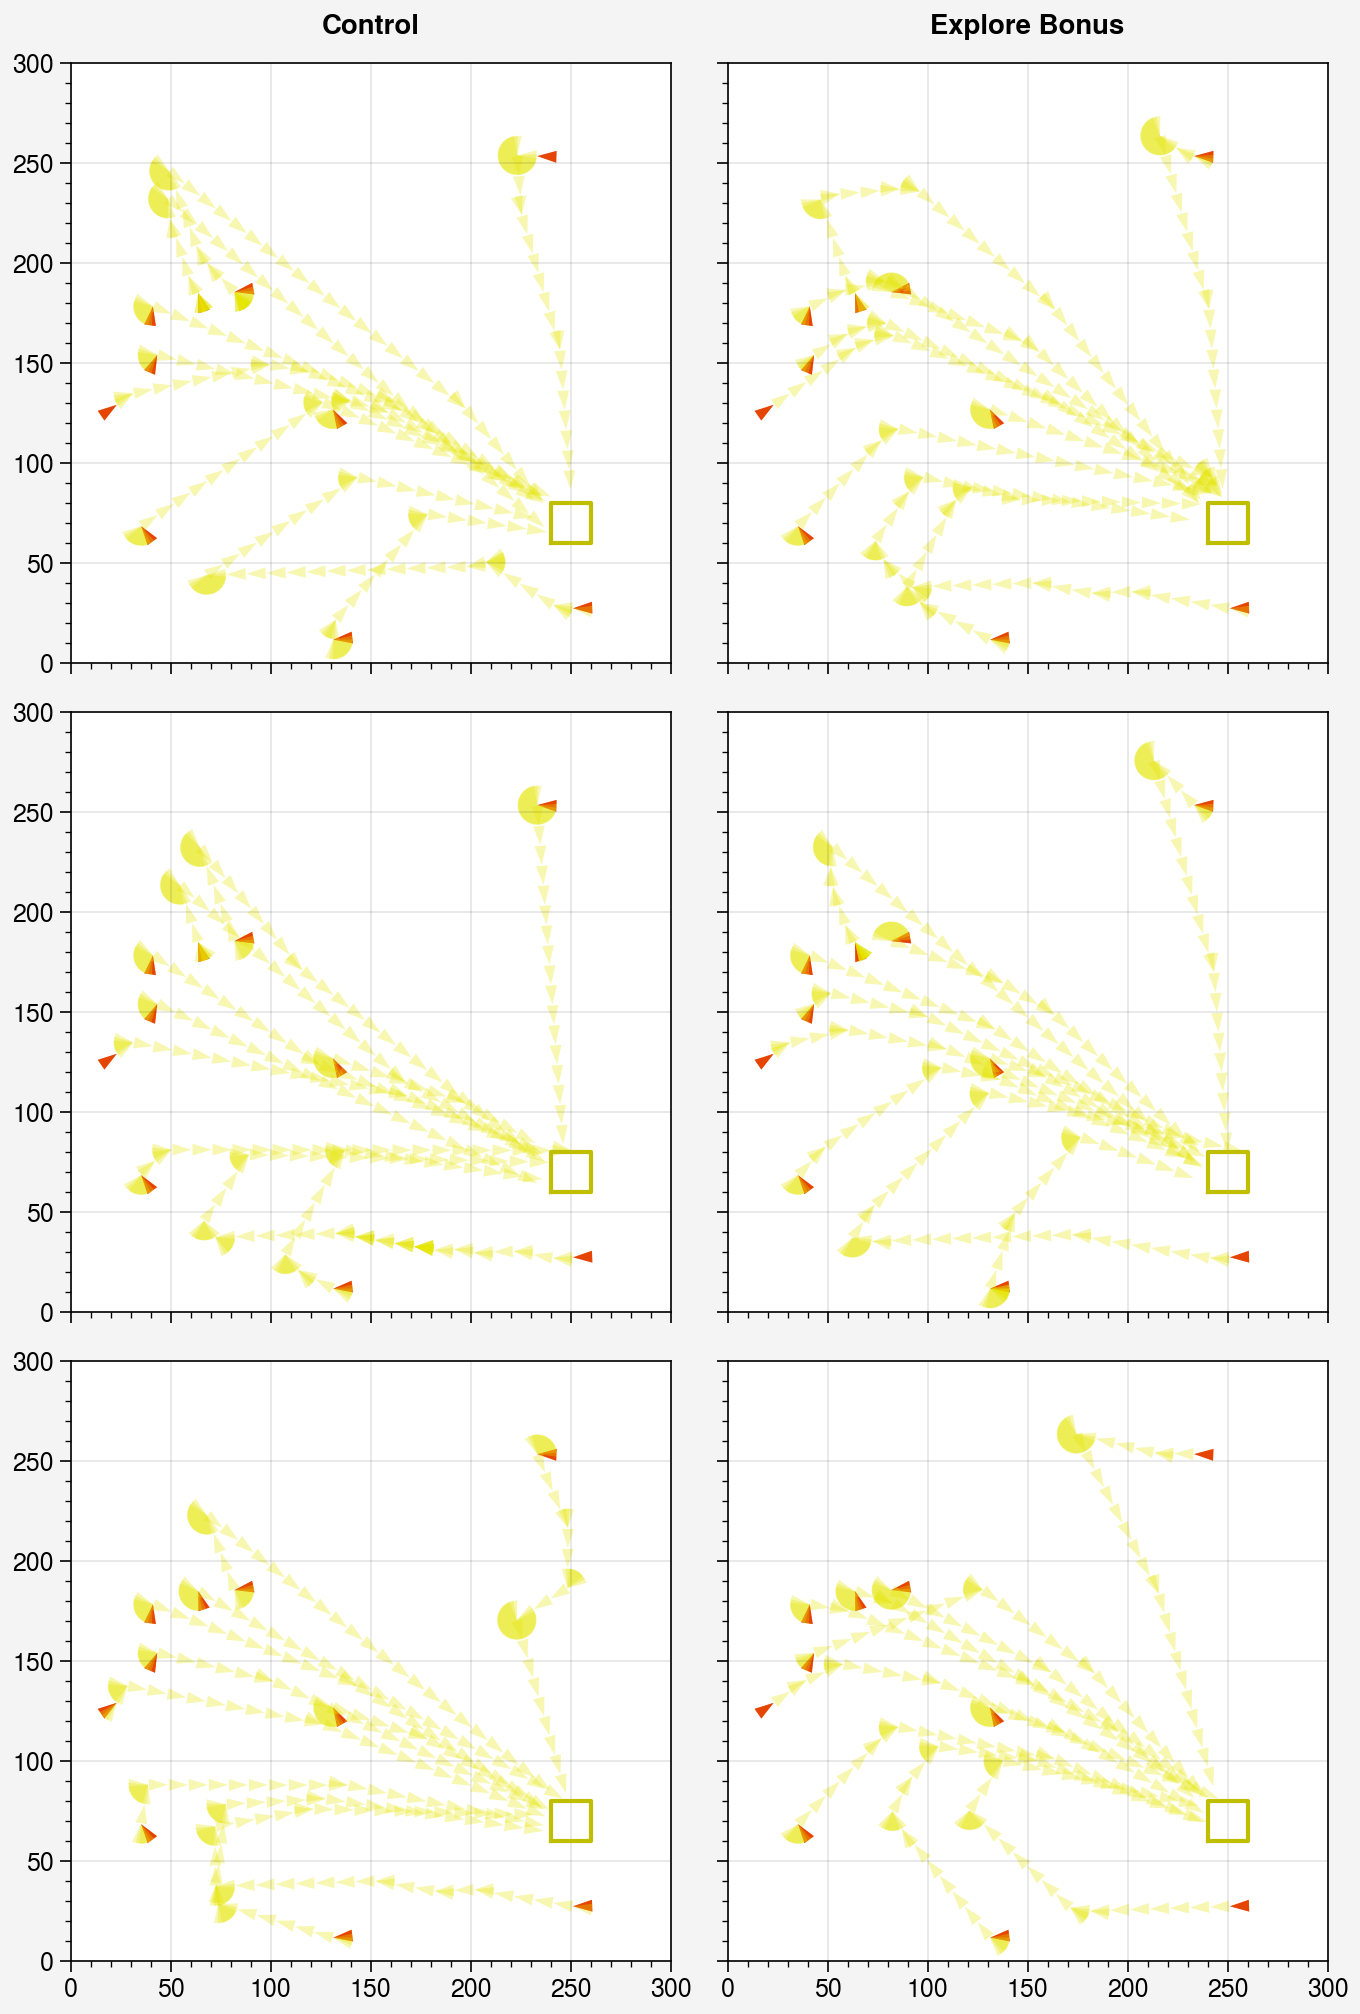

In [88]:
aux_tasks = ['none', 'rewexplore']
aux_task_labels = ['Control', 'Explore Bonus']
batch = 32

ncols = 2
nrows = 3

fig, axs = pplt.subplots(ncols=ncols, nrows=nrows, refwidth=3)
axs.format(xlim=(0, 300), ylim=(0, 300), toplabels=aux_task_labels)

ress = []

# for n, ax in enumerate(ax):

for x in range(nrows):
    for y in range(ncols):
        aux = aux_tasks[y]
        ax = axs[x, y]
    
        exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}'
        model, obs_rms, kwargs = load_model_and_env(exp_name, x)

        res = evalu(model, obs_rms, n=10, data_callback=poster_data_callback, env_kwargs=kwargs)
        ress.append(res)

        ep_pos = split_by_ep(np.vstack(res['data']['pos']), res['dones'])
        ep_angle = split_by_ep(np.vstack(res['data']['angle']), res['dones'])
        draw_box(ax=ax)
        for pos, angles in zip(ep_pos, ep_angle):
            for i, (p, a) in enumerate(zip(pos, angles)):
                if i == 0:
                    draw_character(p, a, ax=ax, draw_color=[0.9, 0, 0, 1])
                draw_character(p, a, ax=ax)